# Notebook used to visualize the mean instantenous power consumed by the labeled electrical components, as depicted in the data descriptor

## Load packages and basic dataset information

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import patches
            
import matplotlib
%matplotlib inline

import h5py
import pandas as pd
import os
import sys
from pathlib import Path
from datetime import datetime
from datetime import timedelta
import math
import seaborn as sns
import pdb
import scipy
# Add project path to path for import
project_path = os.path.abspath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

# Add module path to path for import
module_path = os.path.abspath("../data_utility/data_utility.py")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data_utility import CREAM_Day # class to work with a day of the CREAM Dataset

# Intentional replication is necessary
%load_ext autoreload
# Reload all modules every time before executing the Python code typed.
%autoreload 2 
# Import some graphical modules
from IPython.display import display, clear_output
from ipywidgets import Button, Layout, ButtonStyle, HBox, VBox, widgets, Output
from IPython.display import SVG, display, clear_output
from scipy.stats import describe 
import subprocess
import glob

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
PATH_TO_DATA = os.path.abspath(os.path.join("..", "..","rbgstorage", "nilm", "i13-dataset", "CREAM"))


In [57]:
def get_mean_instant_power_values(path_to_data, machine_name, window_size=0.4):
    path_to_data = os.path.join(path_to_data, machine_name)
    all_days = glob.glob(os.path.join(path_to_data, "*"))
    all_days = [os.path.basename(d) for d in all_days if "2018" in os.path.basename(d)  or "2019" in os.path.basename(d)  ]
    all_days.sort()
    
    # Load the events 
    day_path = os.path.join(path_to_data, all_days[0]) #arbitrary day to initialize the object
    current_CREAM_day = CREAM_Day(cream_day_location=day_path,use_buffer=True, buffer_size_files=2) 

    # Load the electrical component events
    if machine == "X9":
        all_component_events = current_CREAM_day.load_component_events(os.path.join(path_to_data, "component_events_fine.csv"), filter_day=False)

    else:
        all_component_events = current_CREAM_day.load_component_events(os.path.join(path_to_data, "component_events.csv"), filter_day=False)
    
    mean_instant_power_list = []
    component_list = []
    for index, component in enumerate( np.unique(all_component_events.Component), start=1):
        if component == "unlabeled": #skip the unlabeled ones
            continue

        component_events = all_component_events[all_component_events.Component == component]

        component_events = component_events.sample(n=100, random_state=10)
        # for efficienfy reasons, iterate over each day separately
        for day_date in np.unique(component_events.Date):

            for event in component_events[component_events.Date == day_date].itertuples():
                cream_day = CREAM_Day(cream_day_location=os.path.join(path_to_data, str(day_date)), use_buffer=True, buffer_size_files=10)
                voltage, current = cream_day.load_time_frame(event.Timestamp, duration=window_size, return_noise=False)
                instant_power = voltage * current
                mean_instant_power_list.append(np.mean(instant_power))
                component_list.append(component)

    component_list = np.array(component_list)
    mean_instant_power_list = np.array(mean_instant_power_list)

    filename = "./instant_pow_"  + machine_name + ".npy"
    with open(filename, 'wb') as f:
        np.save(f, component_list)
        np.save(f, mean_instant_power_list)
    return component_list, mean_instant_power_list

In [52]:
comp = []
mean_i_pow = []
for i, machine in enumerate([ "X8", "X9"]):
    component_list, mean_instant_power_list = get_mean_instant_power_values(path_to_data=PATH_TO_DATA,
                                 machine_name=machine)
    comp.append(component_list)
    mean_i_pow.append(mean_instant_power_list)

# Plot the mean instantantenous power of the labeled electrical components, i.e., heater, millingplant and pump

### Due to the number of heater events, we sample 100 events of each component to compute the mean power

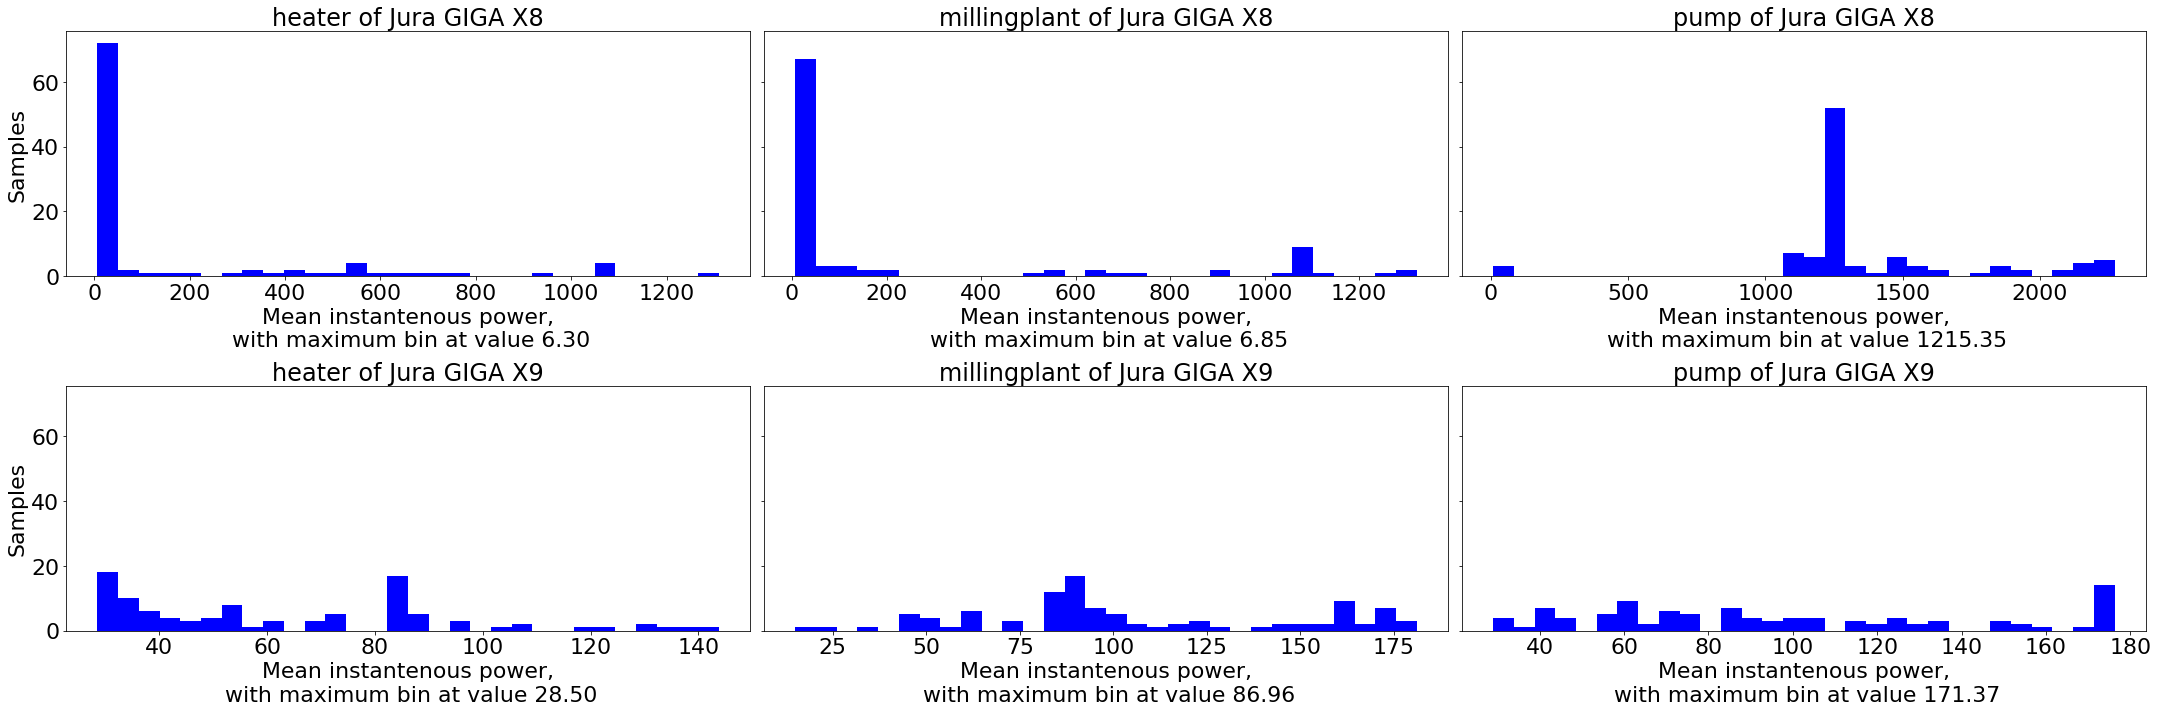

In [58]:
comp = []
mean_i_pow = []

fig, ax = plt.subplots(2, 3, figsize=(30,10), sharex=False, sharey=True)
window_size = 0.3
    
for row_i, machine_name in enumerate(["X8", "X9"]): 
    filename = "./instant_pow_"  + machine_name + ".npy"
    with open(filename, 'rb') as f:
        component_list = np.load(f)
        mean_instant_power_list = np.load(f)
        comp.append(component_list)
        mean_i_pow.append(mean_instant_power_list)
        
    for i, component in enumerate(np.unique(component_list)):
        mask = np.where(component_list == component)[0]
        hist, bins = np.histogram(mean_instant_power_list[mask], bins=30)
        biggest_bin = np.argmax(hist) # get biggest bin and its value
        x, y, _ = ax[row_i, i].hist(mean_instant_power_list[mask], bins, color="b")

        max_bin = np.argmax(x)
        max_value = y[max_bin]

        title_text  = component + " of Jura GIGA " + machine_name
        ax[row_i, i].set_title(title_text, fontsize=24)
        #ax[row_i, i].set_ylim(0,60)
        if i == 0: #set y label only for the outer, left plots
            ax[row_i, i].set_ylabel("Samples", fontsize=22)
        ax[row_i, i].set_xlabel("Mean instantenous power,\n with maximum bin at value %.2f" %(max_value), fontsize=22)
        ax[row_i, i].tick_params(axis='both', which='major', labelsize=22)
        ax[row_i, i].tick_params(axis='both', which='minor', labelsize=20)
fig.tight_layout()
fig.savefig("./Figure_4_BOTH.pdf")
plt.show()